In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Reentry Chile Response Rate

*Sebastian Daza*

In this report we describe response rates by wave. We follow these general criteria:

- The estimation by wave only uses cases far beyond the wave-specific observation window. For instance, for the wave 2-months, we only consider those women who have been in the study for 4 months.
- This estimation is based on the administrative records of the study.

Some important definitions:

- Names of waves: baseline, week, two_months, six_months, twelve_months
- Variables names: `d` means date, `c` means clean, and `cd` clean date
- Deadline corresponds to th time threshold to compute a given response rate

We display key date variables to compute the rates and highlight inconsistencies or problems. 

In [86]:
# getting paths
import os
file = os.getcwd() + '/data/registroEncuestadorasGeneral.xlsx'

## Release
There are two date of release variables
in the register data. *Definitive* has a bunch of missing records. **We should define a validated and unique date for release**. 

In [87]:
import pandas as pd
import numpy as np
import re 

In [88]:
# old code

# path = '/Users/sdaza/Desktop/seguimiento/'
# files = os.listdir(path)

#  # exclude temp files and DS_Store
# cfiles = [re.findall(r'^[a-zA-Z].+', file) for file in files]
# cfiles = list(filter(None, cfiles))
# cfiles

# # read data
# df = pd.DataFrame()
# for file in cfiles:
#     if file: 
#         t = pd.read_excel(path+file[0], skiprows=[0,1])
#         t.rename(columns=lambda x: x.strip(), inplace=True) # remove spaces
#         df = df.append(t, ignore_index=True)

In [89]:
# read excel file
df = pd.read_excel(file, skiprows=[0,1])

In [90]:
df.columns = df.columns.str.strip()

In [91]:
# extract columns
cols = ['enc_final','folio','fegresoefectiva', 'lb_fechaentrevista', 'lb_participa', 
       'primsem_fechaentrevista', 'primsem_participa', 'dosmeses_fechaentrevista', 
        'dosmeses_participa', 'seismeses_fechaentrevista', 'seismeses_participa', 
       'docemeses_fechaentrevista', 'docemeses_participa']

df = df.loc[:,cols]
df.shape

(226, 13)

In [92]:
df.head()

,enc_final,folio,fegresoefectiva,lb_fechaentrevista,lb_participa,primsem_fechaentrevista,primsem_participa,dosmeses_fechaentrevista,dosmeses_participa,seismeses_fechaentrevista,seismeses_participa,docemeses_fechaentrevista,docemeses_participa
0,Susana,10003,2016-09-16,02-09-2016,Sí,2016-09-23,Sí,2016-11-29,Si,2017-05-10,SI,2017-10-03 00:00:00,SI
1,Javi,10007,2016-09-20,12-09-2016,Sí,2016-09-27,Sí,2016-11-28,Si,2017-04-07,SI,2017-10-02 00:00:00,SI
2,Pati,10011,2016-09-23,09-09-2016,Sí,2016-09-22,Sí,2016-11-21,Si,NaT,NO,NaN,NaN
3,Pati,10015,2016-09-25,20-09-2016,Sí,NaT,No,2016-12-08,Si,2017-06-01,no,NaN,NaN
4,Javi,10016,2016-09-26,15-09-2016,Sí,NaT,No,NaT,No,NaT,NO,NaN,NaN


In [93]:
# rename columns
names = ["int","id", "release_f","dbaseline","r_baseline",
         "dweek","r_week","d2months","r_2months",
         "d6months","r_6months","d12months","r_12months"]

df.rename(columns=dict(zip(cols, names)), inplace=True)

In [94]:
df.head()

,int,id,release_f,dbaseline,r_baseline,dweek,r_week,d2months,r_2months,d6months,r_6months,d12months,r_12months
0,Susana,10003,2016-09-16,02-09-2016,Sí,2016-09-23,Sí,2016-11-29,Si,2017-05-10,SI,2017-10-03 00:00:00,SI
1,Javi,10007,2016-09-20,12-09-2016,Sí,2016-09-27,Sí,2016-11-28,Si,2017-04-07,SI,2017-10-02 00:00:00,SI
2,Pati,10011,2016-09-23,09-09-2016,Sí,2016-09-22,Sí,2016-11-21,Si,NaT,NO,NaN,NaN
3,Pati,10015,2016-09-25,20-09-2016,Sí,NaT,No,2016-12-08,Si,2017-06-01,no,NaN,NaN
4,Javi,10016,2016-09-26,15-09-2016,Sí,NaT,No,NaT,No,NaT,NO,NaN,NaN


In [95]:
null = df.int.notnull()
df = df.loc[null, names]

In [96]:
df.shape

(226, 13)

In [97]:
# remove cases?
remove_cases = [10011] # only case that's not valid

# df.id in remove_cases
df = df.loc[~df.id.isin(remove_cases),:]
df.shape

(225, 13)

In [98]:
# save data
import dill

dill.dump(df, open('data/registro.pkl', 'wb'))

# load the data
df = dill.load(open('data/registro.pkl', 'rb'))

In [99]:
# no valid records for release_f?
s = df.release_f.isnull()
s.describe()

count       225
unique        1
top       False
freq        225
Name: release_f, dtype: object

In [100]:
#df.loc[s, 'release'] = df.loc[s, 'release_o']

In [101]:
# start = pd.to_datetime("09/01/2016")
# s = (df.release < start) & (df.release_o >= start)
# df.loc[s, ['release']] = df.loc[s, ['release_o']]
df['release_year'] = pd.DatetimeIndex(df['release_f']).year
df['release_month'] = pd.DatetimeIndex(df['release_f']).month

# year and months
# print(df.release_year.value_counts())
# print(df.release_month.value_counts())

In [102]:
# release plot
t = df.reset_index().set_index('release_f')
t = t.resample('M')

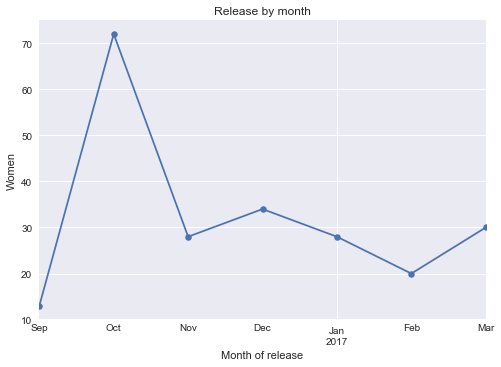

In [103]:
ax = t.id.count().plot(title='Release by month', style='.-', ms=13);
ax.set_ylabel("Women");
ax.set_xlabel("Month of release");

## Baseline

Let's explore the baseline information. Below a plot with the distribution of the difference between the date of the baseline and release. All values should be **negative**. 

To check cases below where we have issues: missing data or positive value (i.e., the baseline was applied after release). 

In [104]:
# baseline response
# varname = [col for col in df.columns if 'sí: se realizó línea base' in col]
#print(varname)
# df = df.rename(columns={'lb_response': 'r_baseline'})
# df
# df.r_baseline.value_counts()
# df['r_baseline'] = df['r_baseline'].str.contains("s|S")

In [105]:
# correct some dates
df.loc[df.dbaseline.isnull(),['int','id', 'dbaseline', 'r_baseline']]

,int,id,dbaseline,r_baseline
44,Marisol,10291,NaN,Sí
190,Marcela,50060,NaN,0.708333


In [106]:
# error with id 20112
df.loc[df.id == 20112]
df.loc[df.id == 20112, 'dbaseline'] = '2016-10-19'

In [107]:
# function to clean dates
def clean_dates(text):
   if (isinstance(text, str)):
      text = str(text)
      pp = re.compile("-|\.")
      r = re.sub(pp, "/", text)
      pp = re.compile("([0-9]+/[0-9]+/[0-9]+)|([0-9]+-[0-9]+-[0-9]+)")
      r = re.search(pp, r)
      if (r is not None):
         r = r.group()
      else:
         r = ''
   else:
      r = text
   return pd.to_datetime(r, dayfirst=True, errors = 'coerce')

In [108]:
df['cdbaseline'] = [clean_dates(i) for i in df['dbaseline']]

In [109]:
# m = df['cdbaseline'].isnull() & df['dbaseline'].notnull()
# df.loc[m, ['int', 'id', 'cdbaseline', 'dbaseline']]

In [110]:
# replace errors in data entry
# errors = ['V16/12716', 'V14 y M18/10']
# new_values = ['12/16/16', '10/18/16']
# 
# for i in range(0,len(errors)):
#    df.loc[df['dbaseline'] == errors[i], 'cdbaseline'] = pd.to_datetime(new_values[i])

In [111]:
# identify inconsistent cases
# df.release_baseline.describe()
# ax = df.release_baseline.hist(bins = 40);
# ax.set_xlabel('Baseline date - Release');

In [112]:
df = df.assign(release_baseline = (df.cdbaseline - df.release_f).dt.days) # it has to be negative
s = ((df.release_baseline > 0) | (df.cdbaseline.isnull()))
df.loc[s, ['int', 'id', 'r_baseline', 'release_f',  'cdbaseline', 'dbaseline', 'release_baseline']].sort_values('id')

,int,id,r_baseline,release_f,cdbaseline,dbaseline,release_baseline
44,Marisol,10291,Sí,2017-03-22,NaT,NaN,NaN
187,Marcela,50037,SI,2016-10-19,2017-09-30,2017-09-30 00:00:00,346.0
190,Marcela,50060,0.708333,2016-10-19,NaT,NaN,NaN


Descriptives of the difference between release date and baseline: 

In [113]:
df.release_baseline.describe()

count    223.000000
mean     -11.511211
std       36.756915
min     -367.000000
25%      -14.000000
50%       -7.000000
75%       -4.000000
max      346.000000
Name: release_baseline, dtype: float64

## First week


Below a plot with the distribution of the difference between the date of the first week interview and release. All values should be **positive**. 


In [114]:
# varname = [col for col in df.columns if 'participa' in col]
# print(varname)

In [115]:
# df = df.rename(columns={varname[1]: 'r_week'})
#df.r_week.value_counts()
df['r_week'] = df['r_week'].str.contains("s|S").astype(float)
df['r_week'] = df.r_week.fillna(0)
#df.r_week.isnull().value_counts()
df.r_week.value_counts()

1.0    181
0.0     44
Name: r_week, dtype: int64

In [116]:
# varname = [col for col in df.columns if 'fecha' in col]
#print(varname)

In [117]:
# varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [118]:
# df = df.rename(columns={varname[0]: 'dweek'})

In [119]:
df['cdweek'] = [clean_dates(i) for i in df['dweek']]
#df.cdweek.describe()

In [120]:
m = df.cdweek.isnull() & df.dweek.notnull()
# df.loc[m, ['id', 'cdweek', 'dweek']]

In [121]:
# # replace errors in data entry
# errors = ['S29/10 y W02/11']
# new_values = ['11/02/2016']

# for i in range(0,len(errors)):
#    df.loc[df['dweek'] == errors[i], 'cdweek'] = pd.to_datetime(new_values[i])

# s = (df.r_week == 1)
# #df.loc[s, 'cdweek'].isnull().value_counts()

In [122]:
df = df.assign(release_week = (df.cdweek - df.release_f).dt.days)
(df.release_week > 7).value_counts()

True     145
False     80
Name: release_week, dtype: int64

Plot of the difference between date of release and first week interview.

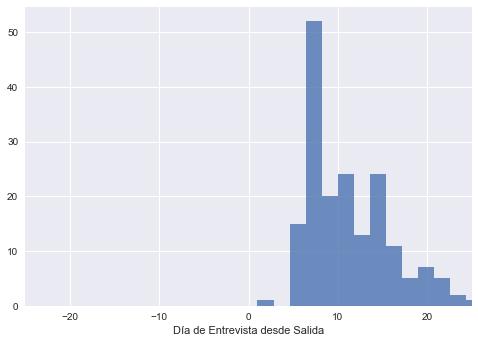

In [123]:
ax = df.release_week.hist(bins = 20, alpha = 0.8);
ax.set_xlim(-25,25)
ax.set_xlabel('Día de Entrevista desde Salida');

In [124]:
df['week_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(weeks = 5) # five weeks!

Cases with issues: 

In [125]:
import datetime
today = datetime.datetime.now()
s = ((df.r_week == 1) & (today > df.week_deadline)) & ( (df.release_week <= 0) | (df.cdweek.isnull()) )

# df.loc[s,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']].sort_values('id')

In [126]:
df.loc[np.abs(df.release_week) > 30,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']]

,int,id,r_week,release_f,cdweek,release_week
11,Susana,10053,1.0,2016-10-19,2016-11-25,37.0


Interviews before the first 7 days:

In [127]:
df.loc[df.release_week < 7,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']]

,int,id,r_week,release_f,cdweek,release_week
70,Pati,20181,1.0,2016-12-09,2016-12-15,6.0
80,Pati,20239,1.0,2017-02-01,2017-02-06,5.0
145,Susana,40019,1.0,2016-10-01,2016-10-07,6.0
151,Susana,40046,1.0,2016-10-19,2016-10-25,6.0
156,Susana,40066,1.0,2016-10-19,2016-10-25,6.0
162,Susana,40107,1.0,2016-12-01,2016-12-06,5.0
165,Susana,40122,1.0,2016-11-01,2016-11-07,6.0
166,Susana,40152,1.0,2016-11-16,2016-11-22,6.0
167,Susana,40156,1.0,2016-11-20,2016-11-25,5.0
168,Susana,40166,1.0,2016-11-30,2016-12-05,5.0


Response rate:

In [128]:
tab  = df.loc[ (today > df.week_deadline) | (df.r_week == 1), 'r_week'].value_counts()
rr_week = [i / sum(list(tab)) for i in tab][0]
print(rr_week)

0.804444444444


Descriptives of the difference between date of release and interview first week. 

In [129]:
df.loc[df.r_week == 1, 'release_week'].describe()

count    181.000000
mean      11.287293
std        4.932354
min        1.000000
25%        8.000000
50%       10.000000
75%       14.000000
max       37.000000
Name: release_week, dtype: float64


# Two Months
 

In [130]:
# varname = [col for col in df.columns if 'participa ' in col]
#print(varname)

In [131]:
# df = df.rename(columns={varname[0]: 'r_2months'})
#df.r_2months.value_counts()
df['r_2months'] = df['r_2months'].str.contains("s|S").astype(float)
df['r_2months'] = df.r_2months.fillna(0)
#df.r_2months.isnull().value_counts()
#df.r_2months.value_counts()

In [132]:
# date 2months
# varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [133]:
# df = df.rename(columns={varname[0]: 'd2months'})

In [134]:
df['cd2months'] = [clean_dates(i) for i in df['d2months']]

Some cases with issues:

In [135]:
m = df.cd2months.isnull() & df.d2months.notnull()
df.loc[m, ['id', 'release', 'cd2months', 'd2months']]

,id,release,cd2months,d2months


In [136]:
# replace errors in data entry
# errors = ['27/2']
# new_values = ['02/27/2017']

# for i in range(0,len(errors)):
#    df.loc[df['d2months'] == errors[i], 'cd2months'] = pd.to_datetime(new_values[i])

In [137]:
s = (df.r_2months == 1)
#df.loc[s, 'cd2months'].isnull().value_counts()

In [138]:
df = df.assign(release_2months = (df.cd2months - df.release_f).dt.days)
#df.release_2months.describe()

Plot of the difference between release and date of two-months interview.

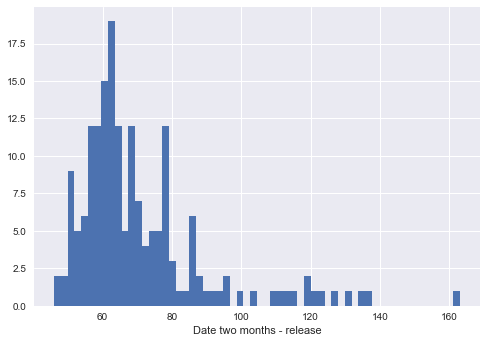

In [139]:
ax = df.release_2months.hist(bins = 60);
ax.set_xlabel('Date two months - release');

Some issues:

In [140]:
df['two_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 5)
s = ((df.r_2months == 1) & (today > df.two_months_deadline)) & ( (df.release_2months <= 0) | (df.cd2months.isnull()))
df.loc[s,['int', 'id', 'r_2months', 'release_f', 'cd2months', 'two_months_deadline', 'release_2months']].sort_values('id')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months


In [141]:
tab  = df.loc[ (today > df.two_months_deadline) | (df.r_2months == 1), 'r_2months'].value_counts()
# print(tab)
rr_2months = [i / sum(list(tab)) for i in tab][0]
# print(rr_2months)

In [142]:
df.loc[np.abs(df.release_2months) > 100,['int', 'id', 'r_2months', 'release_f', 
                                         'cd2months', 'two_months_deadline', 
                                         'release_2months']].sort_values('release_2months')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months
44,Marisol,10291,1.0,2017-03-22,2017-07-04,2017-08-22,104.0
221,Marcela,50249,1.0,2017-02-09,2017-05-30,2017-07-09,110.0
36,Javi,10233,1.0,2017-01-25,2017-05-17,2017-06-25,112.0
17,Javi,10087,1.0,2016-10-19,2017-02-09,2017-03-19,113.0
166,Susana,40152,1.0,2016-11-16,2017-03-11,2017-04-16,115.0
209,Marcela,50180,1.0,2016-12-07,2017-04-05,2017-05-07,119.0
78,Pati,20224,1.0,2017-01-16,2017-05-16,2017-06-16,120.0
223,Marisol,50271,1.0,2017-03-06,2017-07-06,2017-08-06,122.0
225,Marcela,50281,1.0,2017-03-12,2017-07-13,2017-08-12,123.0
211,Marcela,50205,1.0,2016-12-28,2017-05-03,2017-05-28,126.0


In [143]:
df.loc[np.abs(df.release_2months) < 10 ,['int', 'id', 
                                         'r_2months', 'release_f', 'cd2months', 
                                         'two_months_deadline', 
                                         'release_2months']].sort_values('release_2months')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months


Descriptives:

In [144]:
df.loc[df.r_2months == 1, 'release_2months'].describe()

count    177.000000
mean      70.666667
std       19.282195
min       46.000000
25%       59.000000
50%       64.000000
75%       78.000000
max      163.000000
Name: release_2months, dtype: float64

## Six Months

In [145]:
#varname = [col for col in df.columns if 'participa ' in col]
#print(varname)

In [146]:
#df = df.rename(columns={varname[0]: 'r_6months'})
df.r_6months.value_counts()
df['r_6months'] = df['r_6months'].str.contains("s|S").astype(float)
df['r_6months'] = df.r_6months.fillna(0)
#df.r_6months.isnull().value_counts()
#df.r_6months.value_counts()

In [147]:
# date 6months
#varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [148]:
#df = df.rename(columns={varname[0]: 'd6months'})
df['cd6months'] = [clean_dates(i) for i in df['d6months']]

m = df.cd6months.isnull() & df.d6months.notnull()
m.value_counts()

False    225
dtype: int64

In [149]:
# df.loc[m, ['id', 'release_f', 'cd6months', 'd6months']]

In [150]:
s = (df.r_6months == 1)
#df.loc[s, 'cd6months'].isnull().value_counts()

There is some issues here:

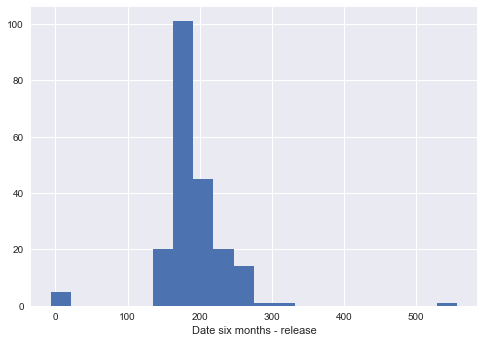

In [151]:
df.loc[df.id == 50209, 'cd6months'] = pd.to_datetime('2017-07-30') # is this right?
df = df.assign(release_6months = (df.cd6months - df.release_f).dt.days)

ax = df.release_6months.hist(bins = 20);
ax.set_xlabel('Date six months - release');

In [152]:
df['six_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 9)

s = ((df.r_6months == 1) & (today > df.six_months_deadline)) & (
    (df.release_6months <= 0) | (df.cd6months.isnull()))

df.loc[s,['int', 'id', 'r_6months', 'release_f', 'd6months', 
          'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

,int,id,r_6months,release_f,d6months,cd6months,six_months_deadline,release_6months
208,Marisol,50175,1.0,2017-01-14,2017-01-08,2017-01-08,2017-10-14,-6.0


In [153]:
# df.loc[df.release_6months < -0,['int', 'id', 'r_6months', 'release_f', 'd6months', 'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

In [154]:
df.loc[np.abs(df.release_6months) > 240, ['int', 'id', 'r_6months', 'release_f', 'cd6months', 
                                          'six_months_deadline', 
                                          'release_6months']].sort_values('release_6months')

,int,id,r_6months,release_f,cd6months,six_months_deadline,release_6months
197,Marisol,50104,1.0,2016-10-24,2017-06-27,2017-07-24,246.0
3,Pati,10015,0.0,2016-09-25,2017-06-01,2017-06-25,249.0
192,Marisol,50070,1.0,2016-10-22,2017-06-29,2017-07-22,250.0
190,Marcela,50060,1.0,2016-10-19,2017-06-26,2017-07-19,250.0
113,Javiera,30139,1.0,2016-11-04,2017-07-12,2017-08-04,250.0
23,Susana,10149,1.0,2016-11-14,2017-07-27,2017-08-14,255.0
96,Javiera,30021,1.0,2016-10-02,2017-06-21,2017-07-02,262.0
205,Marcela,50154,1.0,2016-11-18,2017-08-08,2017-08-18,263.0
204,Marcela,50150,1.0,2016-11-14,2017-08-08,2017-08-14,267.0
109,Javiera,30116,1.0,2016-10-19,2017-07-14,2017-07-19,268.0


In [155]:
tab  = df.loc[(today > df.six_months_deadline)  | (df.r_6months == 1), 'r_6months'].value_counts()
# print(tab)
rr_6months = [i / sum(list(tab)) for i in tab][0]
print(rr_6months)

0.875555555556


Some descriptives:

In [156]:
df.loc[df.r_6months == 1, 'release_6months'].describe()

count    197.000000
mean     194.045685
std       42.895613
min       -6.000000
25%      170.000000
50%      186.000000
75%      208.000000
max      557.000000
Name: release_6months, dtype: float64

# Year

In [157]:
df.r_12months.value_counts()
df['r_12months'] = df['r_12months'].str.contains("s|S").astype(float)
df['r_12months'] = df.r_12months.fillna(0)

In [158]:
df.r_12months.value_counts()

0.0    119
1.0    106
Name: r_12months, dtype: int64

In [159]:
df['cd12months'] = [clean_dates(i) for i in df['d12months']]

m = df.cd12months.isnull() & df.d12months.notnull()
m.value_counts()

False    223
True       2
dtype: int64

In [160]:
s = (df.r_12months == 1)
s.value_counts()

False    119
True     106
Name: r_12months, dtype: int64

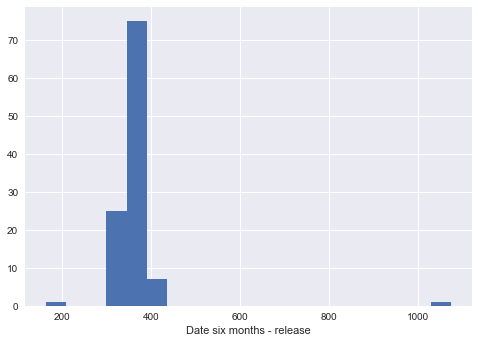

In [161]:
df = df.assign(release_12months = (df.cd12months - df.release_f).dt.days)

ax = df.release_12months.hist(bins = 20);
ax.set_xlabel('Date six months - release');

In [162]:
df['twelve_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 12)

s = ((df.r_12months == 1) & (today > df.twelve_months_deadline)) & (
    (df.release_12months <= 0) | (df.cd12months.isnull()))

df.loc[s,['int', 'id', 'r_12months', 'release_f', 'd12months', 
          'cd12months', 'twelve_months_deadline', 'release_12months']].sort_values('id')

,int,id,r_12months,release_f,d12months,cd12months,twelve_months_deadline,release_12months
192,Marisol,50070,1.0,2016-10-22,NaN,NaT,2017-10-22,NaN


In [163]:
tab  = df.loc[(today > df.twelve_months_deadline)  | (df.r_12months == 1), 'r_12months'].value_counts()
# print(tab)
rr_12months = [i / sum(list(tab)) for i in tab][0]
print(rr_12months)

0.697368421053


In [164]:
df.loc[np.abs(df.release_12months) > 380, ['int', 'id', 'r_12months', 'release_f', 'cd12months', 
                                          'twelve_months_deadline', 
                                          'release_12months']].sort_values('release_12months')

,int,id,r_12months,release_f,cd12months,twelve_months_deadline,release_12months
0,Susana,10003,1.0,2016-09-16,2017-10-03,2017-09-16,382.0
152,Susana,40050,1.0,2016-10-19,2017-11-06,2017-10-19,383.0
67,Pati,20161,0.0,2016-11-18,2017-12-07,2017-11-18,384.0
22,Pati,10119,1.0,2016-10-17,2017-11-06,2017-10-17,385.0
59,Pati,20081,1.0,2016-10-19,2017-11-09,2017-10-19,386.0
13,Marisol,10074,1.0,2016-10-19,2017-11-09,2017-10-19,386.0
58,Pati,20071,1.0,2016-10-20,2017-11-12,2017-10-20,388.0
145,Susana,40019,1.0,2016-10-01,2017-10-26,2017-10-01,390.0
10,Marisol,10052,1.0,2016-10-19,2017-11-14,2017-10-19,391.0
108,Javiera,30110,1.0,2016-10-19,2017-11-15,2017-10-19,392.0


In [165]:
df.loc[df.r_12months == 1, 'release_12months'].describe()

count     105.000000
mean      365.466667
std        74.631153
min       164.000000
25%       346.000000
50%       358.000000
75%       372.000000
max      1074.000000
Name: release_12months, dtype: float64

# Plot of interview days by wave

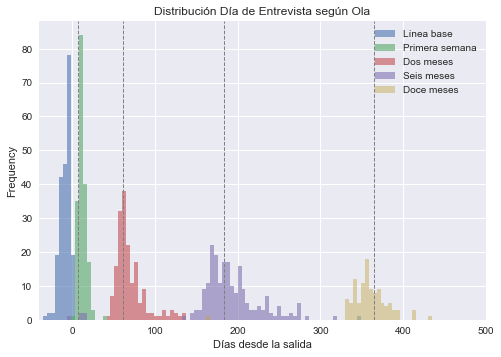

In [166]:
ax = df.loc[:, ['release_baseline', 'release_week', 'release_2months', 
                'release_6months', 'release_12months']].plot.hist(
    title='Distribución Día de Entrevista según Ola', alpha=0.6, bins = 300)
ax.set_xlim(-40,500)
ax.legend(['Línea base', 'Primera semana', 'Dos meses', 'Seis meses', 'Doce meses'])
ax.axvline(7, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*2, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*6, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(365.0, color = 'gray', linestyle ='--', linewidth=1)
ax.set_xlabel('Días desde la salida');
plt.savefig('plots/dia_entrevista_ola.pdf', dpi = 600)

## Summary rates

In [167]:
rr = pd.DataFrame( {"rate" : [rr_week, rr_2months, rr_6months, rr_12months]}, 
                       index = ['week' ,'2 months', '6 months', '12 months'])

rr

,rate
week,0.804444
2 months,0.786667
6 months,0.875556
12 months,0.697368


In [168]:
# s = ['id', 'r_week', 'r_2months', 'r_6months', 'interviewer']
# df.loc[:,s].to_csv('/Users/sdaza/Dropbox/Projects/re-entry/10 investigadores/sdaza/reports-github/reports/data/clean_register.csv')